# Adversarial Image Captioning Attack

### Import Libraries, Set Seeds, and Select GPU

In [3]:
# Standard libraries
import json
import os

# Third party packages
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, ViTImageProcessor, VisionEncoderDecoderModel

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [4]:
# GPU setup
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


### Load COCO Mini Dataset

In [6]:
# Download dataset
data_path = kagglehub.dataset_download(
    "nagasai524/mini-coco2014-dataset-for-image-captioning")

In [7]:
def load_captions(dataset_path):
    """Load image_id -> list of captions mapping from captions.json."""
    captions_path = os.path.join(dataset_path, "captions.json")
    with open(captions_path, "r") as f:
        data = json.load(f)

    annotations = data["annotations"] if isinstance(data, dict) else data

    captions = {}
    for ann in annotations:
        img_id = ann["image_id"]
        captions.setdefault(img_id, []).append(ann["caption"])
    return captions

In [8]:
def find_image_folder(dataset_path, ext=".jpg"):
    """Find first folder under dataset_path that contains image files."""
    for root, _, files in os.walk(dataset_path):
        if any(f.lower().endswith(ext) for f in files):
            return root
    raise RuntimeError(f"No image folder with *{ext} found under {dataset_path}")

In [11]:
captions = load_captions(data_path)
img_folder = find_image_folder(data_path)
img_ids = sorted(captions.keys())

print(f"Dataset loaded, {len(img_ids)} images with captions")

Dataset loaded, 18783 images with captions


### Image Loading Helper

In [12]:
def get_image(idx):
    """Load image and its captions by index in img_ids."""
    img_id = img_ids[idx]

    # Try common filename patterns
    candidates = [
        os.path.join(img_folder, f"COCO_train2014_{img_id:012d}.jpg"),
        os.path.join(img_folder, f"{img_id}.jpg"),
    ]

    for img_path in candidates:
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            return img, captions[img_id]

    raise FileNotFoundError(f"No image file found for image_id {img_id}")


### Visual Inspection of a Sample Image

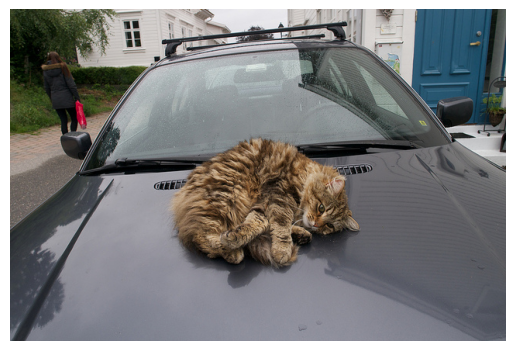

Image index: 6000, image_id: 190360
Ground truth captions:
  - A fluffy cat sleeping on the hood of a car
  - A cat is laying on a car parked in a road in front of houses with a person standing in the background
  - A cat is lying awake on a car hood
  - The cat is lying down on top of a black car
  - Cat relaxing on the hood of a car in an alley


In [50]:
# Choose an image to show
idx = 6000

img, caps = get_image(idx)

plt.imshow(img)
plt.axis("off")
plt.show()

print(f"Image index: {idx}, image_id: {img_ids[idx]}")
print("Ground truth captions:")
for cap in caps:
    print(f"  - {cap}")


### Load ViT-GPT2

In [17]:
model_name = "nlpconnect/vit-gpt2-image-captioning"

model = VisionEncoderDecoderModel.from_pretrained(
    model_name,
    attn_implementation="eager").to(device)

feature_extractor = ViTImageProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.eval()

print(f"Loaded model: {model_name}")
print(f"Decoder attention implementation: {model.config.decoder._attn_implementation}")

Loaded model: nlpconnect/vit-gpt2-image-captioning
Decoder attention implementation: eager


In [18]:
@torch.no_grad()
def generate_caption_and_attention(img, max_length=16):
    """
    Generate a caption for a PIL image and return:
    - caption (str)
    - cross_attentions (list of tensors)
    - encoder_hidden_states (tensor)
    """
    # Image -> pixel_values
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)

    # Encode image
    encoder_outputs = model.encoder(pixel_values=pixel_values)
    encoder_hidden_states = encoder_outputs.last_hidden_state  # [1, 197, hidden_dim]

    # Generate caption ids
    generated_ids = model.generate(
        pixel_values,
        max_length=max_length,
        num_beams=1)

    # Run decoder once over full sequence to get cross-attentions
    decoder_outputs = model.decoder(
        input_ids=generated_ids,
        encoder_hidden_states=encoder_hidden_states,
        output_attentions=True,
        return_dict=True,
        use_cache=False)

    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return caption, decoder_outputs.cross_attentions, encoder_hidden_states


In [19]:
def aggregate_cross_attention(cross_attentions, img_size, patch_size=14):
    """
    Aggregate cross-attention over heads and tokens into a 2D heatmap
    in image resolution (sentence-based aggregation).
    
    cross_attentions: list of tensors, each [1, num_heads, tgt_len, src_len]
                      src_len = 1 (CLS) + patch_size^2
    img_size: (width, height) of the original image
    """
    # Take last decoder layer (most informative)
    last_layer = cross_attentions[-1]          # [1, num_heads, tgt_len, src_len]
    last_layer = last_layer.squeeze(0)         # [num_heads, tgt_len, src_len]

    # Average over heads and decoder tokens
    avg_over_heads = last_layer.mean(dim=0)    # [tgt_len, src_len]
    avg_over_tokens = avg_over_heads.mean(dim=0)  # [src_len]

    # Drop CLS token and keep only patch tokens
    patch_attention = avg_over_tokens[1:]      # [patch_size^2]

    # Reshape to patch grid
    attention_map = patch_attention.reshape(patch_size, patch_size).cpu().numpy()

    # Normalize to [0, 1]
    attention_map -= attention_map.min()
    denom = attention_map.max() if attention_map.max() > 0 else 1e-8
    attention_map /= denom

    # Upsample to original image size
    w, h = img_size
    attn_img = Image.fromarray((attention_map * 255).astype(np.uint8))
    attn_resized = attn_img.resize((w, h), resample=Image.BICUBIC)

    return np.array(attn_resized) / 255.0

In [20]:
def show_image_and_attention(img, caption, attention_heatmap):
    """Plot original image, attention heatmap, and overlay."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 1) Original image
    axes[0].imshow(img)
    axes[0].set_title(f"Original image\nCaption: '{caption}'", fontsize=10)
    axes[0].axis("off")

    # 2) Heatmap only
    axes[1].imshow(attention_heatmap, cmap="hot")
    axes[1].set_title("Cross-attention heatmap\n(sentence-based)", fontsize=10)
    axes[1].axis("off")

    # 3) Overlay
    axes[2].imshow(img)
    axes[2].imshow(attention_heatmap, cmap="hot", alpha=0.5)
    axes[2].set_title("Attention overlay\n(red = high attention)", fontsize=10)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


### Example: Pick an Image, Get Caption and Attention and Visualize

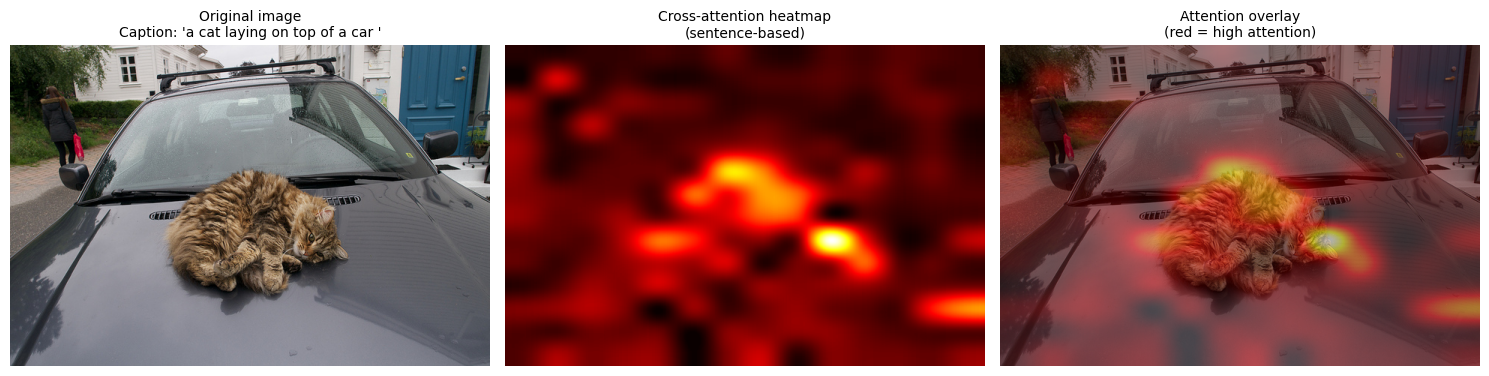

Image index: 6000, image_id: 190360

Ground-truth captions:
  - A fluffy cat sleeping on the hood of a car
  - A cat is laying on a car parked in a road in front of houses with a person standing in the background
  - A cat is lying awake on a car hood
  - The cat is lying down on top of a black car
  - Cat relaxing on the hood of a car in an alley


In [51]:
img, gt_caps = get_image(idx)

caption, cross_attentions, _ = generate_caption_and_attention(img)
attention_heatmap = aggregate_cross_attention(cross_attentions, img.size)

show_image_and_attention(img, caption, attention_heatmap)

print(f"Image index: {idx}, image_id: {img_ids[idx]}")
print("\nGround-truth captions:")
for cap in gt_caps:
    print(f"  - {cap}")

## Attack Pipeline

### Get the Candidate Mask

In [90]:
def get_topk_candidate_pixels(attention_heatmap, k):
    """
    Select top-k pixels with highest attention as candidate region.
    Returns list of (y, x) indices.
    """
    flat = attention_heatmap.flatten()
    k = min(k, flat.size)
    idxs = np.argpartition(flat, -k)[-k:]
    ys, xs = np.unravel_index(idxs, attention_heatmap.shape)
    return list(zip(ys, xs))


def show_candidate_region(img, attention_heatmap, candidate_pixels):
    """
    Visualize original image and candidate region (pixels we may perturb).
    """
    mask = np.zeros(attention_heatmap.shape, dtype=bool)
    for y, x in candidate_pixels:
        mask[y, x] = True

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Original image
    axes[0].imshow(img)
    axes[0].set_title("Original image")
    axes[0].axis("off")

    # Candidate overlay
    axes[1].imshow(img)
    axes[1].imshow(mask, cmap="Reds", alpha=0.6)
    axes[1].set_title("Candidate region (pixels we may perturb)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

Attack index: 6000
Base caption: 'a cat laying on top of a car '
Number of candidate pixels: 35000


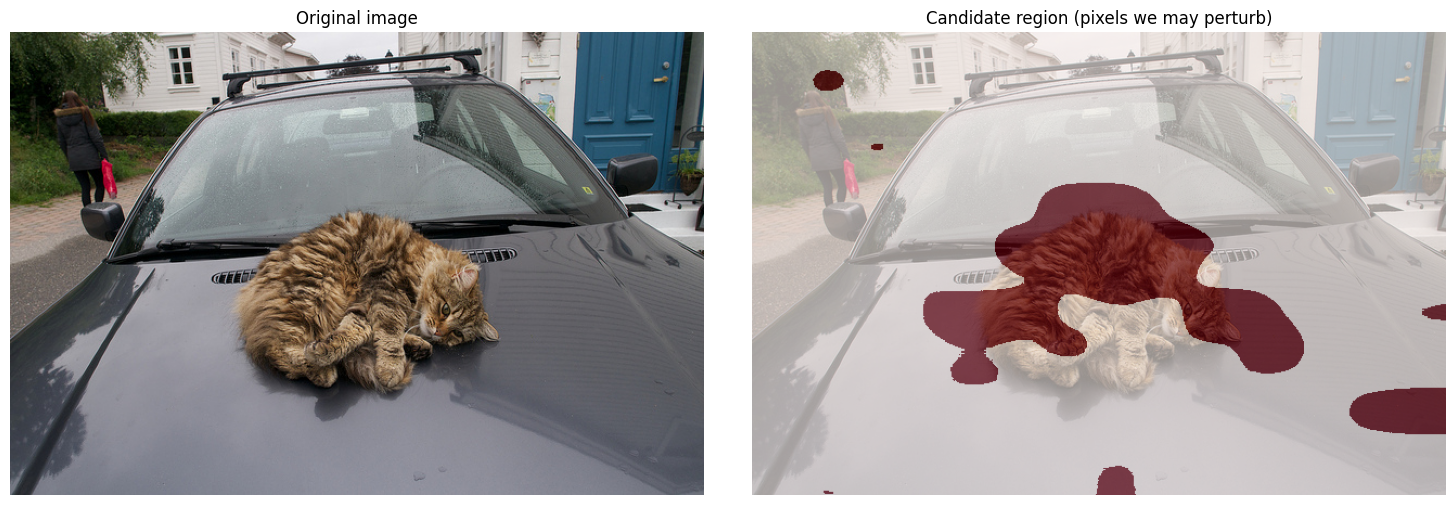

In [94]:
ATTACK_IDX = idx

# Image and Ground Truth Captions
base_img, gt_caps = get_image(ATTACK_IDX)

# 2) Caption + Cross-Attention vom Modell holen
base_caption, cross_attentions, _ = generate_caption_and_attention(base_img)

# 3) Attention-Heatmap aggregieren
attention_heatmap = aggregate_cross_attention(cross_attentions, base_img.size)

# 4) Top-k Pixel als Candidate Region wählen
candidate_pixels = get_topk_candidate_pixels(attention_heatmap, k=35000)

print(f"Attack index: {ATTACK_IDX}")
print(f"Base caption: '{base_caption}'")
print(f"Number of candidate pixels: {len(candidate_pixels)}")

# 5) Candidate Region visualisieren
show_candidate_region(base_img, attention_heatmap, candidate_pixels)


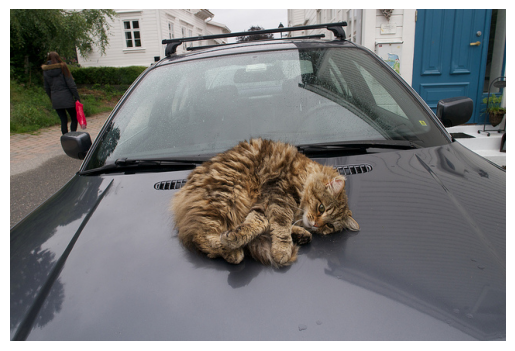

In [101]:
def image_to_array(img):
    """Convert PIL image to uint8 numpy array of shape (H, W, 3)."""
    return np.array(img).astype(np.uint8)


def array_to_image(arr):
    """Convert numpy array (H, W, 3) back to PIL image."""
    return Image.fromarray(arr.astype(np.uint8))


def apply_perturbation(base_array, delta_vec, candidate_pixels):
    """
    Apply a perturbation vector to the candidate pixels of an image.
    
    base_array: numpy array (H, W, 3), uint8
    delta_vec: 1D numpy array of length 3 * len(candidate_pixels)
               [dR1, dG1, dB1, dR2, dG2, dB2, ...]
    candidate_pixels: list of (y, x) positions
    """
    H, W, C = base_array.shape
    assert C == 3, "Expected RGB image"
    num_pixels = len(candidate_pixels)
    assert delta_vec.shape[0] == 3 * num_pixels, "delta_vec length mismatch"

    # work on a float copy so we can add positive/negative deltas
    perturbed = base_array.astype(np.float32).copy()
    deltas = delta_vec.reshape(num_pixels, 3)

    for (y, x), d in zip(candidate_pixels, deltas):
        # add deltas to this pixel (R,G,B)
        perturbed[y, x, :] += d

    # clip back to valid image range
    perturbed = np.clip(perturbed, 0, 255).astype(np.uint8)
    return array_to_image(perturbed)


# base image as numpy array (used for all perturbations)
base_array = image_to_array(base_img)

test_img = apply_perturbation(base_array, test_delta, candidate_pixels)
plt.imshow(test_img)
plt.axis("off")
plt.show()

In [102]:
@torch.no_grad()
def generate_caption(img, max_length=16):
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)
    generated_ids = model.generate(pixel_values, max_length=max_length, num_beams=1)
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)


# Optional sanity check: make sure base_caption matches the current generate() config
print("Base caption (from attention step):", base_caption)
print("Base caption (fresh generate)     :", generate_caption(base_img))


# Prepare token IDs of the base caption (this is the fixed target for the loss)
base_ids = tokenizer(
    base_caption,
    return_tensors="pt",
    add_special_tokens=True,
).input_ids.to(device)


@torch.no_grad()
def caption_loss_for_image(img):
    """
    Compute cross-entropy loss of the fixed base caption given the image.
    Higher loss = caption less compatible with the image.
    """
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)
    outputs = model(pixel_values=pixel_values, labels=base_ids)
    return outputs.loss.item()


# Loss for the original (unperturbed) image
base_loss = caption_loss_for_image(base_img)
print(f"Base loss for original image: {base_loss:.4f}")

Base caption (from attention step): a cat laying on top of a car 
Base caption (fresh generate)     : a cat laying on top of a car 
Base loss for original image: 9.1638


In [105]:
LAMBDA_REG = 0.005  # regularization strength for perturbation size

def fitness(x):
    """
    x: 1D numpy array with length 3 * len(candidate_pixels)
    returns: scalar, higher = better attack but penalized for large perturbations
    """
    perturbed_img = apply_perturbation(base_array, x, candidate_pixels)
    loss = caption_loss_for_image(perturbed_img)
    loss_increase = loss - base_loss  # how much worse the caption fits

    # L2 norm of the perturbation (normalized)
    norm = np.linalg.norm(x) / (255.0 * np.sqrt(x.size))

    # We want high loss_increase but small norm
    return loss_increase - LAMBDA_REG * norm


# Sanity check
num_pixels = len(candidate_pixels)
dim = 3 * num_pixels

print(f"Number of candidate pixels: {num_pixels}")
print(f"Dimension of perturbation vector: {dim}")

x_zero = np.zeros(dim, dtype=np.float32)
score_zero = fitness(x_zero)
print(f"Fitness(x_zero): {score_zero:.4f}")

rng = np.random.default_rng(42)
eps = 20.0
x_rand = rng.uniform(low=-eps, high=eps, size=dim).astype(np.float32)
score_rand = fitness(x_rand)
print(f"Fitness(x_rand): {score_rand:.4f}")

Number of candidate pixels: 35000
Dimension of perturbation vector: 105000
Fitness(x_zero): 0.0000
Fitness(x_rand): -0.0087


In [106]:
def differential_evolution(
    fitness_fn,
    dim,
    pop_size=8,
    generations=5,
    F=0.5,
    CR=0.7,
    eps=20.0,
    random_seed=42):
    """
    Very simple Differential Evolution (DE/rand/1/bin).
    
    fitness_fn: function x -> scalar (higher = better)
    dim: dimensionality of x (here: 3 * len(candidate_pixels))
    pop_size: number of individuals in the population
    generations: number of DE generations
    F: mutation factor
    CR: crossover rate
    eps: initial range for parameters: x ~ U[-eps, +eps]
    """
    rng = np.random.default_rng(random_seed)

    # 1) Initialize population with random vectors
    pop = rng.uniform(low=-eps, high=eps, size=(pop_size, dim)).astype(np.float32)
    fitness_vals = np.array([fitness_fn(ind) for ind in pop], dtype=np.float32)

    best_idx = int(np.argmax(fitness_vals))
    best_x = pop[best_idx].copy()
    best_f = float(fitness_vals[best_idx])

    print(f"Initial best fitness: {best_f:.4f}")

    # 2) Iterate over generations
    for gen in range(generations):
        print(f"\n--- Generation {gen + 1}/{generations} ---")

        for i in range(pop_size):
            # Choose indices for mutation (a, b, c all different and all != i)
            idxs = list(range(pop_size))
            idxs.remove(i)
            a, b, c = rng.choice(idxs, size=3, replace=False)

            x_a, x_b, x_c = pop[a], pop[b], pop[c]

            # Mutation: v = x_a + F * (x_b - x_c)
            v = x_a + F * (x_b - x_c)

            # Crossover: binomial
            cross_mask = rng.random(dim) < CR
            # Ensure at least one component comes from v
            j_rand = rng.integers(0, dim)
            cross_mask[j_rand] = True

            u = np.where(cross_mask, v, pop[i])

            # Evaluate trial vector
            f_u = fitness_fn(u)

            # Selection: keep trial if it is better
            if f_u > fitness_vals[i]:
                pop[i] = u
                fitness_vals[i] = f_u

                # Update global best if necessary
                if f_u > best_f:
                    best_f = float(f_u)
                    best_x = u.copy()

        print(f"Best fitness after generation {gen + 1}: {best_f:.4f}")

    return best_x, best_f

Dimensionality of x: 105000
Initial best fitness: 0.0276

--- Generation 1/3 ---
Best fitness after generation 1: 0.0276

--- Generation 2/3 ---
Best fitness after generation 2: 0.0276

--- Generation 3/3 ---
Best fitness after generation 3: 0.0330

=== Differential Evolution finished ===
Best fitness found (loss increase): 0.0330


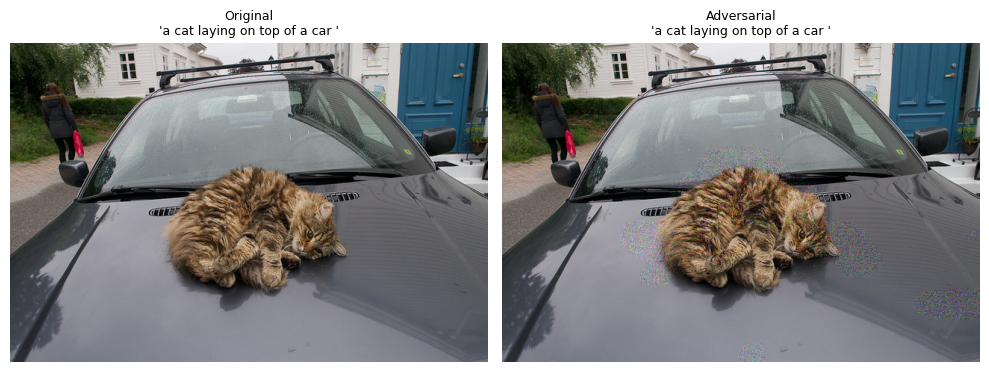


Original caption : 'a cat laying on top of a car '
Adversarial cap. : 'a cat laying on top of a car '
Base loss        : 9.1638
Best loss (base+f): 9.1968


In [111]:
# Dimension of the search space
dim = 3 * len(candidate_pixels)
print(f"Dimensionality of x: {dim}")

best_x, best_f = differential_evolution(
    fitness_fn=fitness,
    dim=dim,
    pop_size=6,      # keep small because each call runs the model
    generations=3,   # small number of iterations for testing
    F=0.6,
    CR=0.7,
    eps=20.0,       # allow strong per-channel perturbations
)

print("\n=== Differential Evolution finished ===")
print(f"Best fitness found (loss increase): {best_f:.4f}")

# Create best adversarial image from the found perturbation
best_img = apply_perturbation(base_array, best_x, candidate_pixels)
best_caption = generate_caption(best_img)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(base_img)
plt.title(f"Original\n'{base_caption}'", fontsize=9)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(best_img)
plt.title(f"Adversarial\n'{best_caption}'", fontsize=9)
plt.axis("off")

plt.tight_layout()
plt.show()

print(f"\nOriginal caption : '{base_caption}'")
print(f"Adversarial cap. : '{best_caption}'")
print(f"Base loss        : {base_loss:.4f}")
print(f"Best loss (base+f): {base_loss + best_f:.4f}")